<a href="https://colab.research.google.com/github/Jesse-abu/NYC_311_Service_Request_Analysis/blob/main/NYC311_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Required packages not available in Colab

In [ ]:
!pip install ydata_profiling
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.7/398.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import f_oneway
from scipy.stats import pearsonr
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from ydata_profiling import ProfileReport

Upload file to colab environmet thorugh google.colab.files

In [ ]:
from google.colab import files

# Upload csv files to jupyter notebook
uploads = files.upload()

for filename in uploads.keys():
  print(f'{filename} Uploaded')

Saving nyc311_subset.csv to nyc311_subset.csv
nyc311_subset.csv Uploaded


In [ ]:
import io

# load data to a pandas dataframe
filename = list(uploads.keys())[0]
df = pd.read_csv(io.BytesIO(uploads[filename]))

# Verify the data
df.info()

/tmp/ipython-input-674774645.py:5: DtypeWarning: Columns (0,11,17,18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.BytesIO(uploads[filename]))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   unique_key              210000 non-null  object 
 1   created_at              209999 non-null  object 
 2   closed_at               180463 non-null  object 
 3   resolution_date_update  195767 non-null  object 
 4   resolution_description  192479 non-null  object 
 5   days_to_close           179301 non-null  float64
 6   agency                  210000 non-null  object 
 7   agency_name             210000 non-null  object 
 8   complaint_type          210000 non-null  object 
 9   descriptor              205273 non-null  object 
 10  location_type           150267 non-null  object 
 11  incident_zip            204273 non-null  object 
 12  incident_address        198267 non-null  object 
 13  city                    193937 non-null  object 
 14  facility_type       

In [ ]:
df.shape

(210000, 22)

In [ ]:
df.head(10)

,unique_key,created_at,closed_at,resolution_date_update,resolution_description,days_to_close,agency,agency_name,complaint_type,descriptor,...,incident_address,city,facility_type,status,borough,latitude,longitude,geo_status,location,zip_codes
0,43859981,2019-09-22 18:01:26,NaN,NaN,NaN,NaN,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Driver Complaint - Non Passenger,...,27 EAST 47 STREET,NEW YORK,NaN,In Progress,MANHATTAN,40.755929,-73.97682,Invalid,"{'longitude': '-73.97681991841992', 'latitude'...",12079.0
1,43859984,2019-09-22 23:40:53,NaN,NaN,NaN,NaN,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Driver Complaint - Non Passenger,...,2483 BROADWAY,NEW YORK,NaN,In Progress,MANHATTAN,40.792324,-73.973492,Invalid,"{'longitude': '-73.97349193224547', 'latitude'...",12422.0
2,43859985,2019-09-22 18:56:16,NaN,NaN,NaN,NaN,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Driver Complaint - Non Passenger,...,333 ADAMS STREET,BROOKLYN,NaN,In Progress,BROOKLYN,40.693598,-73.988904,Invalid,"{'longitude': '-73.98890401269871', 'latitude'...",16865.0
3,43859986,2019-09-22 20:33:06,NaN,NaN,NaN,NaN,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Driver Complaint - Non Passenger,...,18 BOERUM PLACE,BROOKLYN,NaN,In Progress,BROOKLYN,40.691303,-73.989251,Invalid,"{'longitude': '-73.9892505687916', 'latitude':...",16865.0
4,43859987,2019-09-22 13:39:34,2019-09-24 08:36:11,2019-09-24 12:36:12,"After performing a thorough search, the Depart...",1.789317,DOT,Department of Transportation,Ferry Inquiry,Lost and Found,...,SAINT GEORGE FERRY,STATEN ISLAND,NaN,Closed,STATEN ISLAND,40.644145,-74.072645,Invalid,"{'longitude': '-74.07264521772677', 'latitude'...",10369.0
5,43859988,2019-09-22 15:27:37,2019-09-22 16:31:30,2019-09-22 20:31:32,The Police Department responded and upon arriv...,0.044363,NYPD,New York City Police Department,Drinking,In Public,...,600 RIDGEWOOD AVENUE,BROOKLYN,NaN,Closed,BROOKLYN,40.686786,-73.867161,Invalid,"{'longitude': '-73.86716098015863', 'latitude'...",17215.0
6,43859989,2019-09-22 23:16:10,2019-10-01 14:01:39,2019-09-26 21:52:45,NaN,8.614919,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,...,11 GREENE STREET,NEW YORK,NaN,Closed,MANHATTAN,40.720857,-74.002868,Invalid,"{'longitude': '-74.00286802659268', 'latitude'...",12076.0
7,43859990,2019-09-22 21:36:39,2019-09-22 21:36:40,NaN,NaN,0.000012,EDC,Economic Development Corporation,Noise - Helicopter,Other,...,101-21 75 ROAD,FOREST HILLS,NaN,Closed,QUEENS,40.709943,-73.842988,Invalid,"{'longitude': '-73.8429876417836', 'latitude':...",14786.0
8,43859991,2019-09-22 14:43:29,2019-09-22 14:44:43,2019-09-22 18:44:48,The agency was unable to respond to this compl...,0.000856,DPR,Department of Parks and Recreation,Violation of Park Rules,Smoking,...,60-09 SAINT FELIX AVENUE,RIDGEWOOD,NaN,Closed,QUEENS,40.696914,-73.896391,Invalid,"{'longitude': '-73.89639140549146', 'latitude'...",15310.0
9,43859992,2019-09-22 14:31:27,NaN,NaN,NaN,NaN,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Driver Complaint - Non Passenger,...,1321 1 AVENUE,NEW YORK,NaN,In Progress,MANHATTAN,40.767029,-73.956574,Invalid,"{'longitude': '-73.95657432590978', 'latitude'...",12083.0


In [ ]:
# Check if ID is unique and has no missing valiues
caseid_unique = df.unique_key.is_unique;
print(f"IDs are unique: {caseid_unique}")
id_isnull = df.unique_key.isnull();
print(f"IDs missing: {df[id_isnull].shape[0]}")

IDs are unique: True
IDs missing: 0


In [ ]:
df.created_at.unique()

<DatetimeArray>
['2019-09-22 13:39:34', '2019-09-22 15:27:37', '2019-09-22 23:16:10',
 '2019-09-22 21:36:39', '2019-09-22 14:43:29', '2019-09-22 12:42:00',
 '2019-09-22 12:07:00', '2019-09-22 21:25:06', '2019-09-22 22:03:01',
 '2019-09-22 21:12:47',
 ...
 '2019-11-30 13:19:55', '2019-11-30 15:33:25', '2019-11-30 14:22:42',
 '2019-11-30 21:46:44', '2019-11-30 21:55:41', '2019-11-28 15:42:15',
 '2019-11-28 15:44:43', '2019-11-28 15:45:44', '2019-11-28 15:38:20',
 '2019-11-30 22:59:49']
Length: 161176, dtype: datetime64[ns]

In [ ]:
# converting needed columns to datetime and float datatype

cols = ['created_at', 'closed_at', 'resolution_date_update','latitude', 'longitude', 'incident_zip', 'unique_key', 'zip_codes']
for col in cols[0:3]:
    df[col] = pd.to_datetime(df[col],infer_datetime_format=True)

for col in cols[3::]:
  df[col] = pd.to_numeric(df[col], errors='coerce', downcast="float")\

# filter out NAT values in dataset
# Remove rows with NaT values in 'closed_at' column
df = df.dropna(subset=['closed_at'])

# creating a new column Request_Closing_Time
df['Request_Closing_Time'] = df[cols[1]] - df[cols[0]]

# viewing the info to see the data types
df.info()

/tmp/ipython-input-76401316.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col],infer_datetime_format=True)
/tmp/ipython-input-76401316.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col],infer_datetime_format=True)
/tmp/ipython-input-76401316.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remov

<class 'pandas.core.frame.DataFrame'>
Index: 180463 entries, 4 to 209994
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype          
---  ------                  --------------   -----          
 0   unique_key              180463 non-null  float64        
 1   created_at              180463 non-null  datetime64[ns] 
 2   closed_at               180463 non-null  datetime64[ns] 
 3   resolution_date_update  178555 non-null  datetime64[ns] 
 4   resolution_description  175157 non-null  object         
 5   days_to_close           179301 non-null  float64        
 6   agency                  180463 non-null  object         
 7   agency_name             180463 non-null  object         
 8   complaint_type          180463 non-null  object         
 9   descriptor              175829 non-null  object         
 10  location_type           128999 non-null  object         
 11  incident_zip            175499 non-null  float32        
 12  incident_address     

## We will analyse Agency, Complaint Type, Descriptor, Location Type, City, Borough

In [ ]:
# agency complaints were registered to
df.agency.value_counts()

,count
agency,
NYPD,82846
HPD,39310
DOT,17548
DEP,12559
DSNY,9568
DOB,8989
DHS,2665
DPR,2160
DOHMH,2107


In [ ]:
# complaint types
df.complaint_type.value_counts()

,count
complaint_type,
HEAT/HOT WATER,31824
Noise - Residential,23746
Illegal Parking,20377
Blocked Driveway,14904
Noise - Street/Sidewalk,6697
...,...
Cooling Tower,1
Highway Sign - Dangling,1
Adopt-A-Basket,1


<Axes: title={'center': 'Complaint Types'}, xlabel='complaint_type', ylabel='Count'>

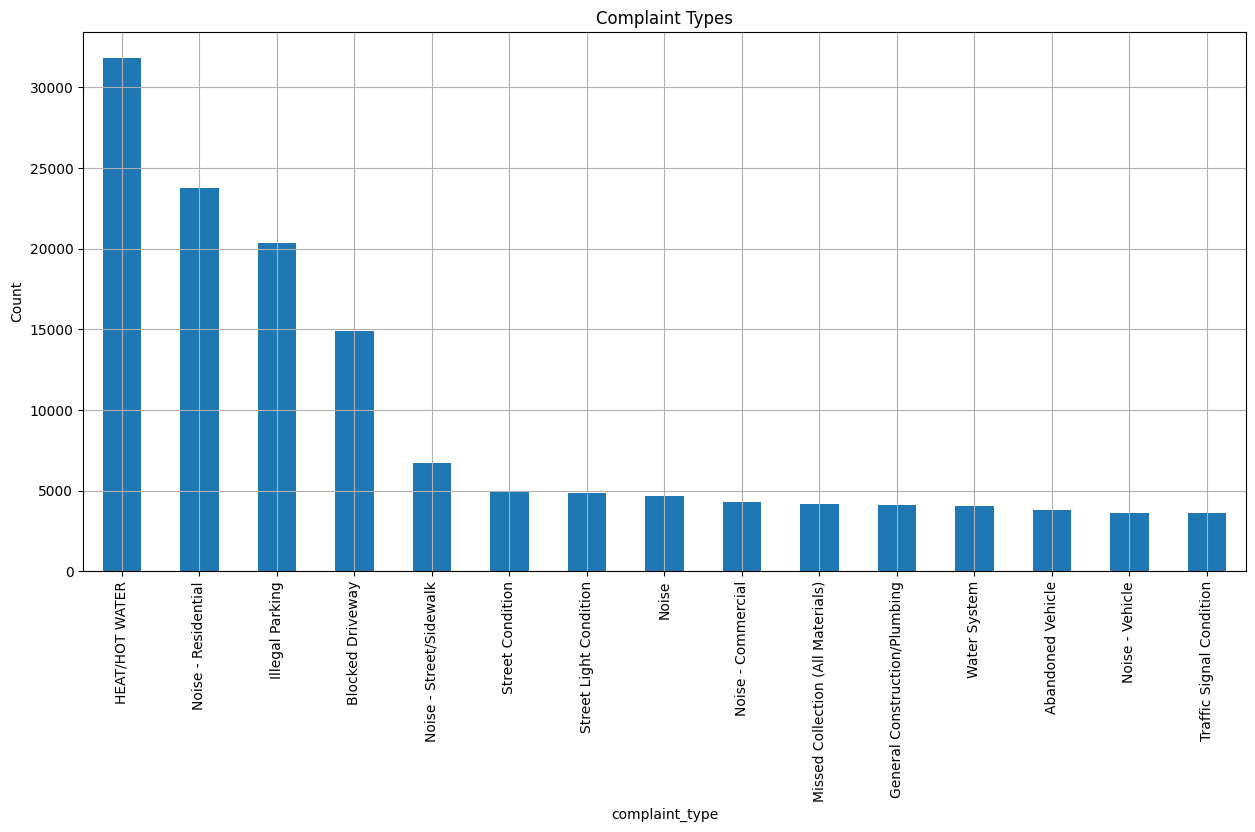

In [ ]:
# plotting the complaint types
df.complaint_type.value_counts().head(15).plot(kind = 'bar', figsize=(15, 7), title='Complaint Types', ylabel='Count', grid=True)


Plot shows HEAT/HOT WATER are the most complaints gotten from citizens

In [ ]:
# Descriptors
df.descriptor.value_counts()

,count
descriptor,
Loud Music/Party,22505
ENTIRE BUILDING,21020
No Access,10824
APARTMENT ONLY,10804
Banging/Pounding,7849
...,...
Electronic Sign - Overhead,1
Fallen Debris from Bridge,1
Decorative Necklace Lighting,1


<Axes: title={'center': 'Top 15 Descriptors'}, ylabel='descriptor'>

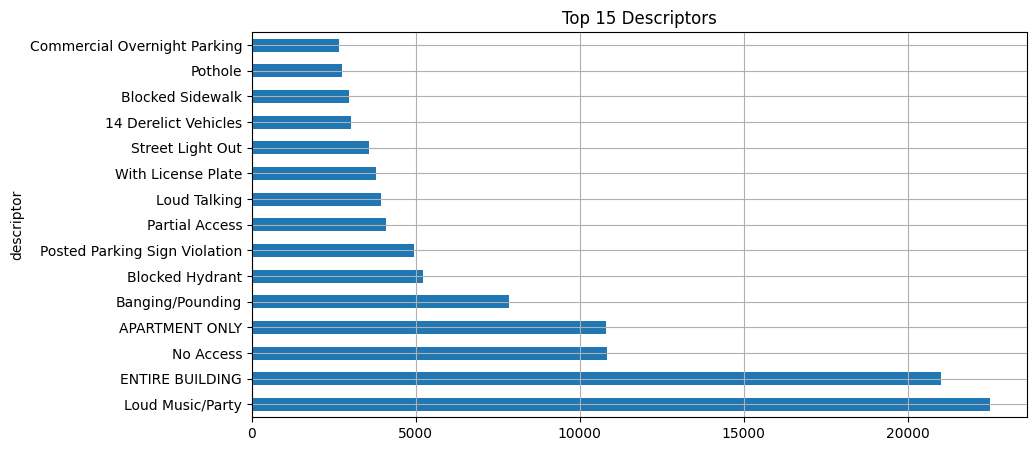

In [ ]:
# plotting top 15 Descriptors
df.descriptor.value_counts().head(15).plot(kind='barh', grid=True, figsize=(10,5), title='Top 15 Descriptors')

In [ ]:
# Top 10 Location Type
df.location_type.value_counts().head(10)

,count
location_type,
Street/Sidewalk,43152
RESIDENTIAL BUILDING,39310
Residential Building/House,20630
Street,7764
Sidewalk,7054
Store/Commercial,3006
Club/Bar/Restaurant,1367
Street/Curbside,754
Bike Lane,701


<Axes: title={'center': 'Top 15 Location Type'}, ylabel='location_type'>

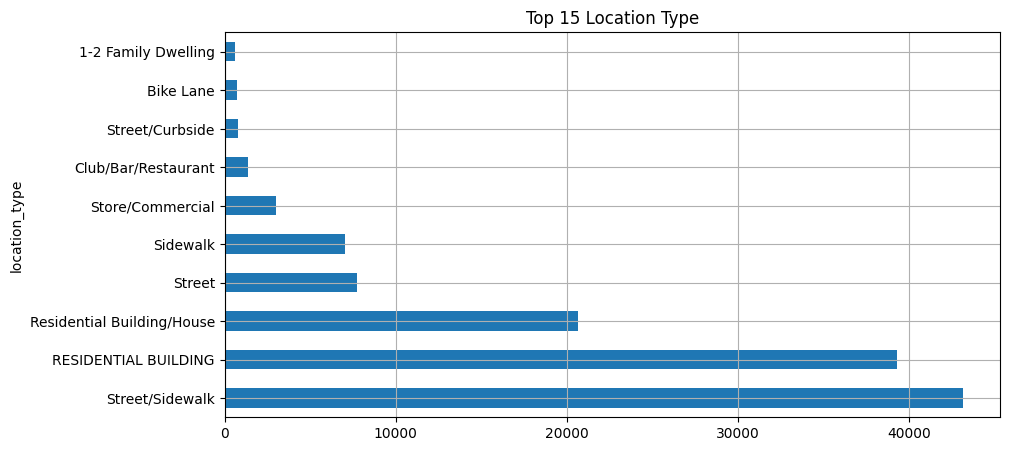

In [ ]:
# plotting Top 15 Location Type
df.location_type.value_counts().head(10).plot(kind='barh', grid=True, figsize=(10, 5), title='Top 15 Location Type')

The location for complaints made are mostly residential Buildings

In [ ]:
# City
df.city.value_counts().head(10)

,count
city,
BROOKLYN,50866
NEW YORK,36334
BRONX,31511
STATEN ISLAND,7270
JAMAICA,4374
ASTORIA,3126
FLUSHING,2886
RIDGEWOOD,2731
FRESH MEADOWS,1762


Text(0.5, 0, 'complaint count')

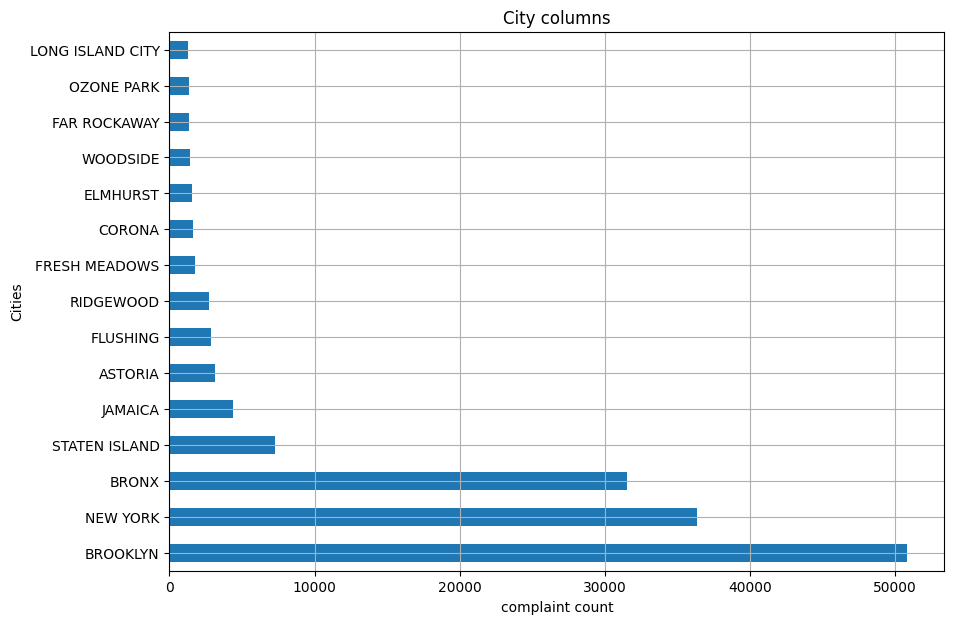

In [ ]:
#Cities
df.city.value_counts().head(15).plot(kind = 'barh', figsize=(10, 7), title='City columns', ylabel='Cities', grid=True)
plt.xlabel('complaint count')

The city with the most complaints was Brooklyn

Text(0.5, 0, 'Complaint Counts')

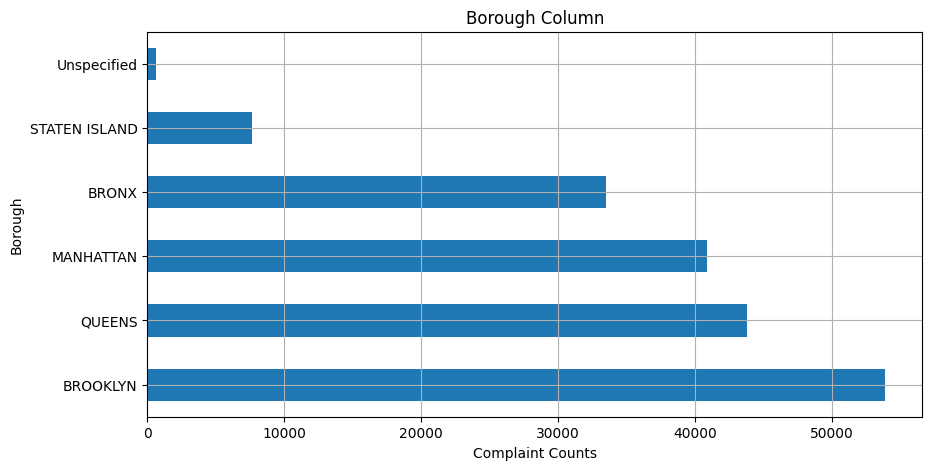

In [ ]:
# Borough
df.borough.value_counts().head(10).plot(kind='barh', grid=True, figsize=(10, 5), title='Borough Column', ylabel='Borough')
plt.xlabel('Complaint Counts')

## Lets analyse Borough and Complaint Types

In [ ]:
# Top Complaints
top_10_complaints = df.complaint_type.value_counts()[:6].keys()
top_10_complaints

Index(['HEAT/HOT WATER', 'Noise - Residential', 'Illegal Parking',
       'Blocked Driveway', 'Noise - Street/Sidewalk', 'Street Condition'],
      dtype='object', name='complaint_type')

In [ ]:
# Borough per Complaints
borough_complaints = df.groupby(['borough', 'complaint_type']).size().unstack()
borough_complaints = borough_complaints[top_10_complaints]
borough_complaints

complaint_type,HEAT/HOT WATER,Noise - Residential,Illegal Parking,Blocked Driveway,Noise - Street/Sidewalk,Street Condition
borough,,,,,,
BRONX,10129.0,5989.0,2243.0,2595.0,1377.0,561.0
BROOKLYN,9442.0,6619.0,7031.0,5497.0,1563.0,1375.0
MANHATTAN,7299.0,5906.0,3397.0,347.0,2773.0,883.0
QUEENS,4724.0,4594.0,6632.0,6055.0,908.0,1579.0
STATEN ISLAND,230.0,638.0,1074.0,410.0,75.0,473.0
Unspecified,NaN,NaN,NaN,NaN,1.0,10.0


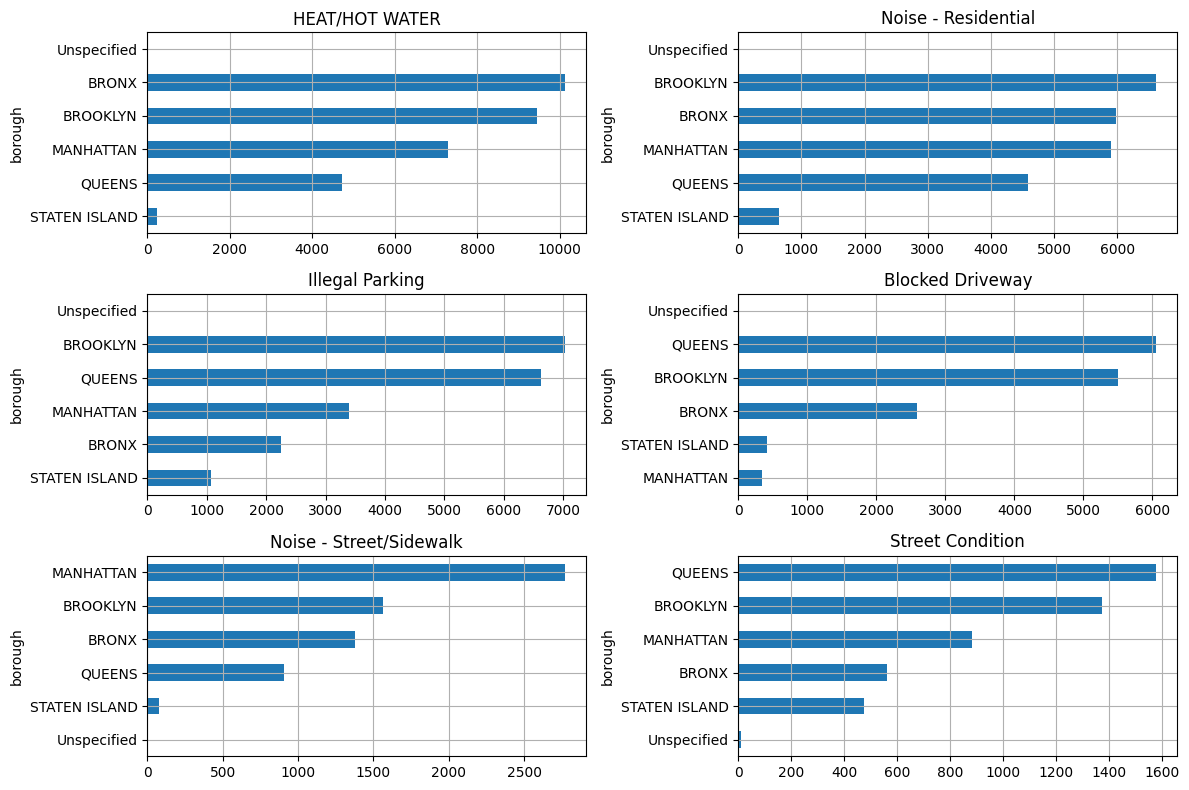

In [ ]:
# Plotting Borough per Complaint Type
col_number = 2
row_number = 3
fig, axes = plt.subplots(row_number,col_number, figsize=(12,8))

for i, (label,col) in enumerate(borough_complaints.items()):
    ax = axes[int(i/col_number), i%col_number]
    col = col.sort_values(ascending=True)[:15]
    col.plot(kind='barh', ax=ax, grid=True)
    ax.set_title(label)

plt.tight_layout()

In [ ]:
# similarly for Complaints per Borough
top_borough = df.borough.value_counts().keys()

complaint_per_borough = df.groupby(['complaint_type', 'borough']).size().unstack()
complaint_per_borough = complaint_per_borough[top_borough]
complaint_per_borough

borough,BROOKLYN,QUEENS,MANHATTAN,BRONX,STATEN ISLAND,Unspecified
complaint_type,,,,,,
APPLIANCE,108.0,35.0,62.0,118.0,13.0,NaN
Abandoned Vehicle,925.0,1886.0,112.0,507.0,350.0,6.0
Adopt-A-Basket,NaN,NaN,NaN,1.0,NaN,NaN
Air Quality,165.0,119.0,234.0,40.0,18.0,NaN
Animal in a Park,42.0,27.0,53.0,18.0,14.0,NaN
...,...,...,...,...,...,...
Violation of Park Rules,34.0,32.0,67.0,28.0,6.0,NaN
WATER LEAK,286.0,65.0,176.0,261.0,13.0,NaN
Water Conservation,52.0,64.0,16.0,25.0,21.0,NaN


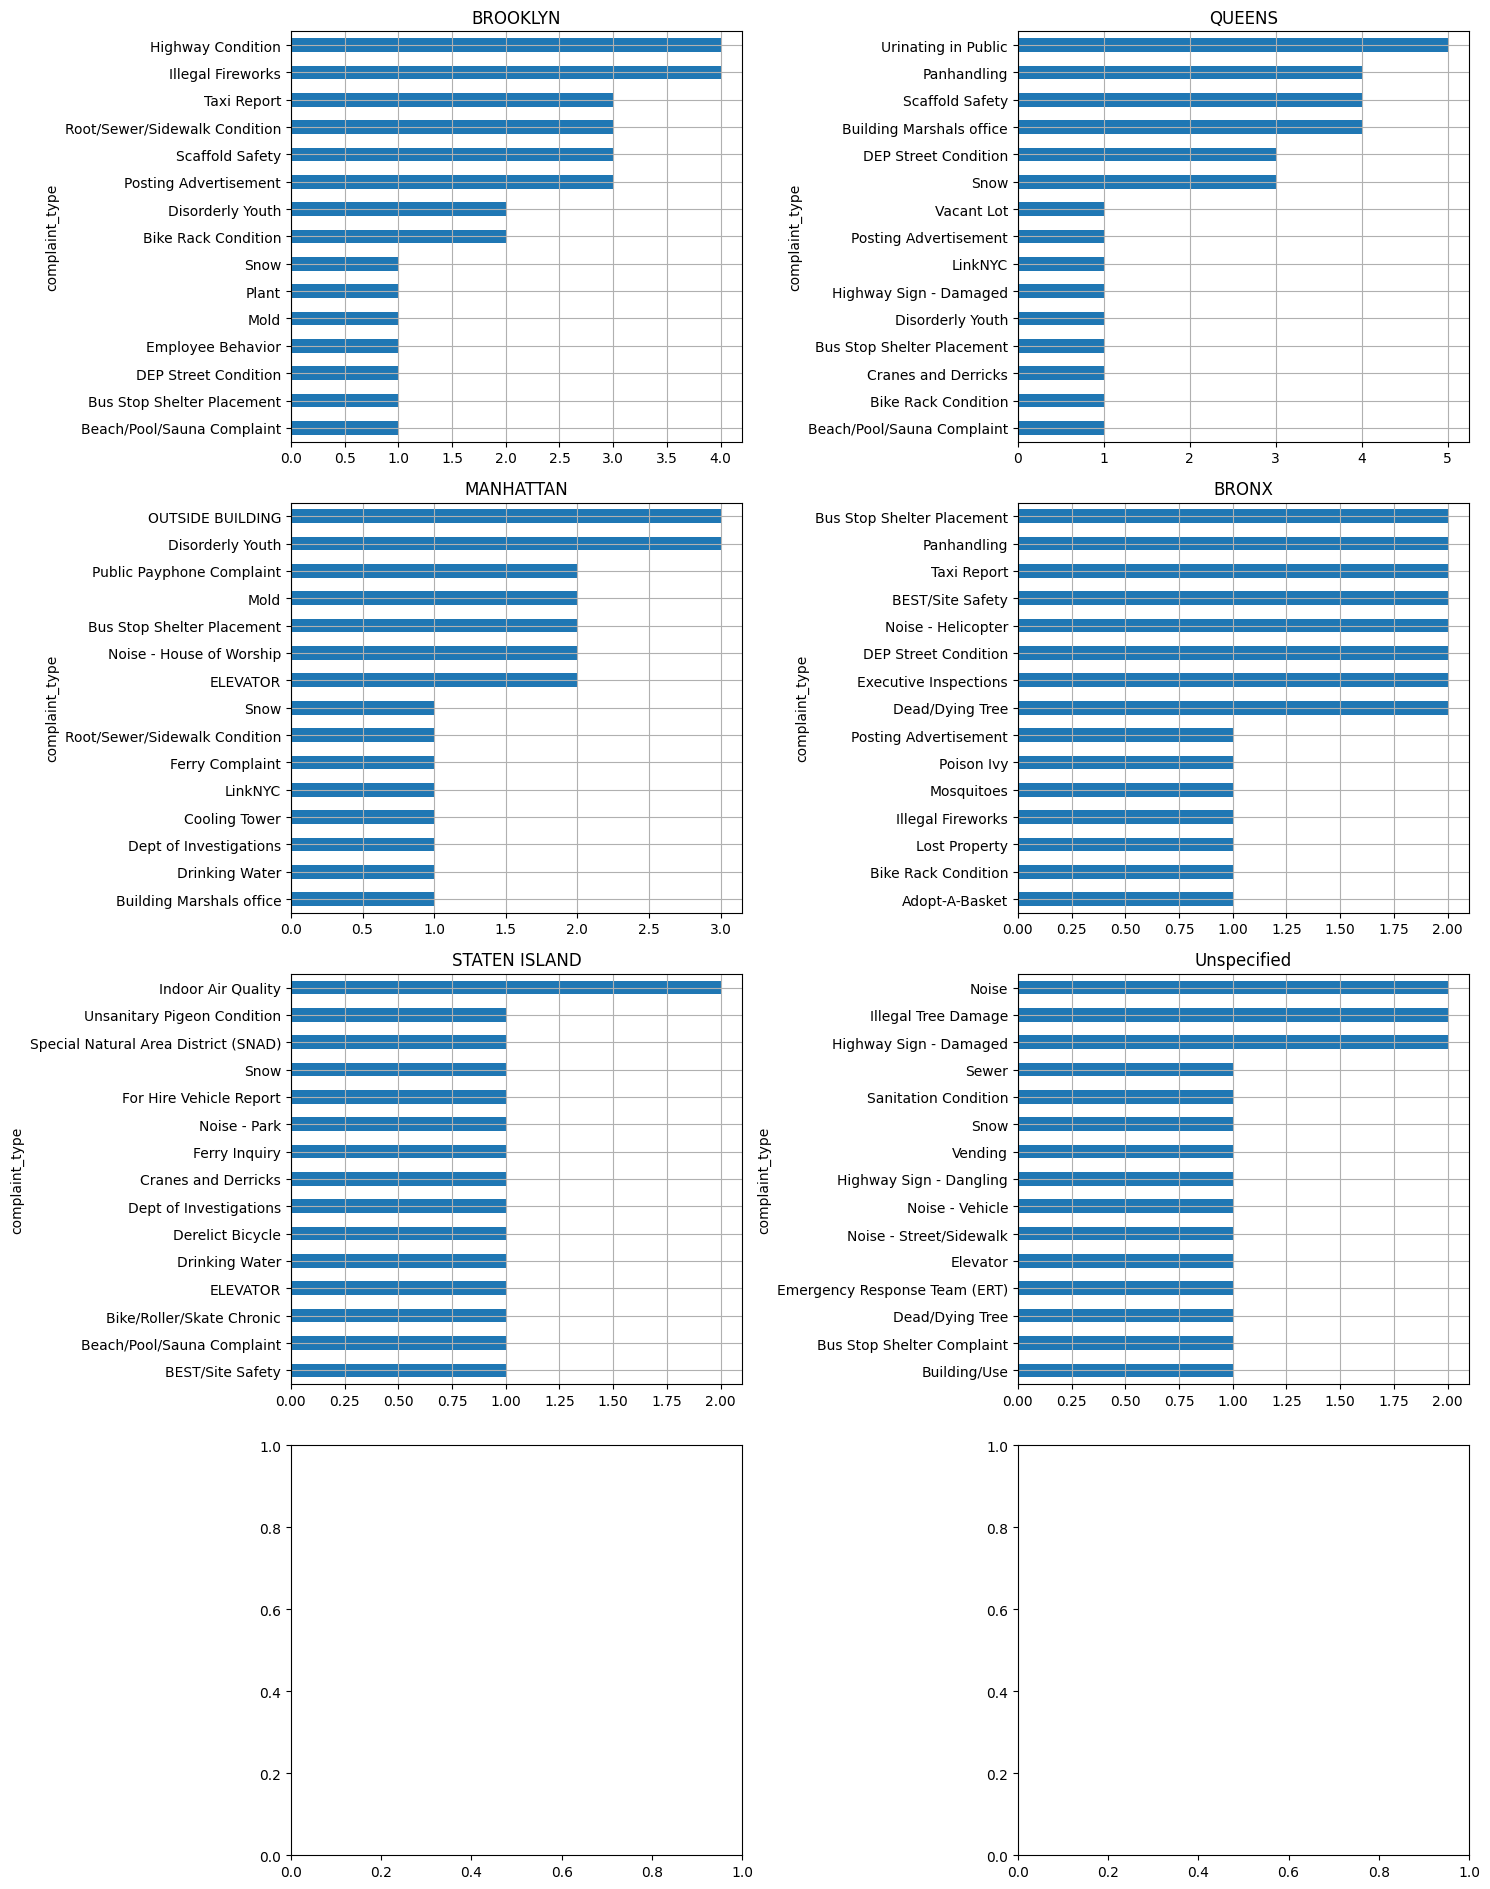

In [ ]:
# Plotting Complaints per Borough
col_number = 2
row_number = 4
fig, axes = plt.subplots(row_number,col_number, figsize=(15,19))

for i, (label,col) in enumerate(complaint_per_borough.items()):
    ax = axes[int(i/col_number), i%col_number]
    col = col.sort_values(ascending=True)[:15]
    col.plot(kind='barh', ax=ax, grid=True)
    ax.set_title(label)

plt.tight_layout()

## Order the complaint types based on the average ‘Request_Closing_Time’, grouping them for different locations.

In [ ]:
df['Request_Closing_Time'].head(10)

,Request_Closing_Time
4,1 days 18:56:37
5,0 days 01:03:53
6,8 days 14:45:29
7,0 days 00:00:01
8,0 days 00:01:14
19,0 days 00:00:00
20,0 days 00:00:00
34,0 days 14:41:24
44,0 days 19:28:12
45,0 days 05:29:19


In [ ]:
# Creating a column Request_Closing_Time_in_Hours for time in Hours
# and we will say the said complaint has been closed under x hours
df['Request_Closing_Time_in_Hours'] = (df['Request_Closing_Time'].dt.total_seconds() / 3600) + 1

# viewing the Two columns side by side for first 15 entries
df[['Request_Closing_Time', 'Request_Closing_Time_in_Hours']].head(15)

,Request_Closing_Time,Request_Closing_Time_in_Hours
4,1 days 18:56:37,43.943611
5,0 days 01:03:53,2.064722
6,8 days 14:45:29,207.758056
7,0 days 00:00:01,1.000278
8,0 days 00:01:14,1.020556
19,0 days 00:00:00,1.000000
20,0 days 00:00:00,1.000000
34,0 days 14:41:24,15.690000
44,0 days 19:28:12,20.470000
45,0 days 05:29:19,6.488611


In [ ]:
#  Ordering the complaint types based on the average ‘Request_Closing_Time’ in Hours, grouping them for different locations.
data_avg_time_in_hrs = df.groupby(['city', 'complaint_type'])['Request_Closing_Time_in_Hours'].mean()
data_avg_time_in_hrs.head(10)

city     complaint_type   
ARVERNE  APPLIANCE            125.233611
         Abandoned Vehicle      4.098796
         Animal-Abuse           3.941667
         Blocked Driveway       2.805853
         Building/Use          71.314306
         DOOR/WINDOW          478.203333
         Derelict Vehicles      3.133333
         Dirty Conditions      93.471429
         Electrical            53.008611
         GENERAL              124.066944
Name: Request_Closing_Time_in_Hours, dtype: float64

In [ ]:
# Creating a column Request_Closing_Time_in_Seconds for time in seconds
df['Request_Closing_Time_in_Seconds'] = df['Request_Closing_Time'].astype('timedelta64[s]')

# viewing the Three columns side by side
df[['Request_Closing_Time', 'Request_Closing_Time_in_Hours','Request_Closing_Time_in_Seconds']].head()

,Request_Closing_Time,Request_Closing_Time_in_Hours,Request_Closing_Time_in_Seconds
4,1 days 18:56:37,43.943611,1 days 18:56:37
5,0 days 01:03:53,2.064722,0 days 01:03:53
6,8 days 14:45:29,207.758056,8 days 14:45:29
7,0 days 00:00:01,1.000278,0 days 00:00:01
8,0 days 00:01:14,1.020556,0 days 00:01:14


In [ ]:
#  Order the complaint types based on the average ‘Request_Closing_Time’ in seconds, grouping them for different locations.
data_avg_in_seconds = df.groupby(['city', 'complaint_type']).Request_Closing_Time_in_Seconds.mean()
data_avg_in_seconds.head(10)

city     complaint_type   
ARVERNE  APPLIANCE            5 days 04:14:01
         Abandoned Vehicle    0 days 03:05:55
         Animal-Abuse         0 days 02:56:30
         Blocked Driveway     0 days 01:48:21
         Building/Use         2 days 22:18:51
         DOOR/WINDOW         19 days 21:12:12
         Derelict Vehicles    0 days 02:08:00
         Dirty Conditions     3 days 20:28:17
         Electrical           2 days 04:00:31
         GENERAL              5 days 03:04:01
Name: Request_Closing_Time_in_Seconds, dtype: timedelta64[s]

In [ ]:
# lets analyse the Request_Closing_Time
df['Request_Closing_Time'].describe()

,Request_Closing_Time
count,180463
mean,2 days 00:55:40.832270326
std,5 days 04:22:27.070590480
min,-47 days +00:00:00
25%,0 days 01:57:46.500000
50%,0 days 08:01:28
75%,1 days 22:17:40.500000
max,67 days 10:26:32


In [ ]:
# Taking the mean and Standard
mean_hrs = df['Request_Closing_Time_in_Hours'].mean()
std_hrs = df['Request_Closing_Time_in_Hours'].std()

mean_seconds = df['Request_Closing_Time_in_Seconds'].mean()
std_seconds = df['Request_Closing_Time_in_Seconds'].std()

print(f'The mean hours is {mean_hrs:.2} hours and mean Seconds is {mean_seconds} seconds')
print(f'The standard hours is {std_hrs:.2f} hours and standard Seconds is {std_seconds} seconds')

The mean hours is 5e+01 hours and mean Seconds is 2 days 00:55:40 seconds
The standard hours is 124.37 hours and standard Seconds is 5 days 04:22:27 seconds


In [ ]:
# for analysing on the basis of month we will need to separate months from Created Date column
df['Year-Month'] = df.created_at.apply(lambda x: datetime.datetime.strftime(x, '%Y-%m') if pd.notna(x) else pd.NaT)

In [ ]:
# viewing the months that we have in our dataset
df['Year-Month'].unique()

array(['2019-09', '2019-10', '2019-11', '2019-12'], dtype=object)

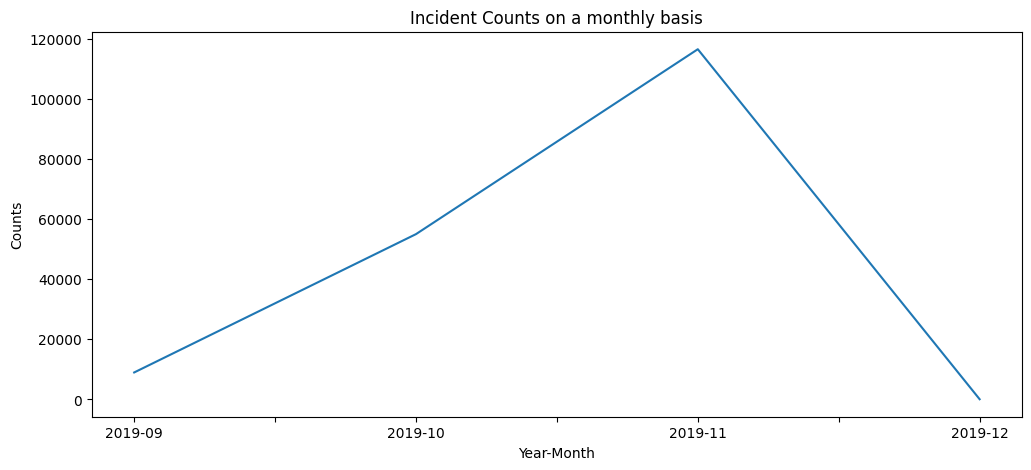

In [ ]:
# plotting the month column
#dataset['Year-Month'].value_counts().plot()
monthly_incidents =  df.groupby('Year-Month').size().plot(figsize=(12,5),
                                                               title='Incident Counts on a monthly basis', ylabel='Counts')

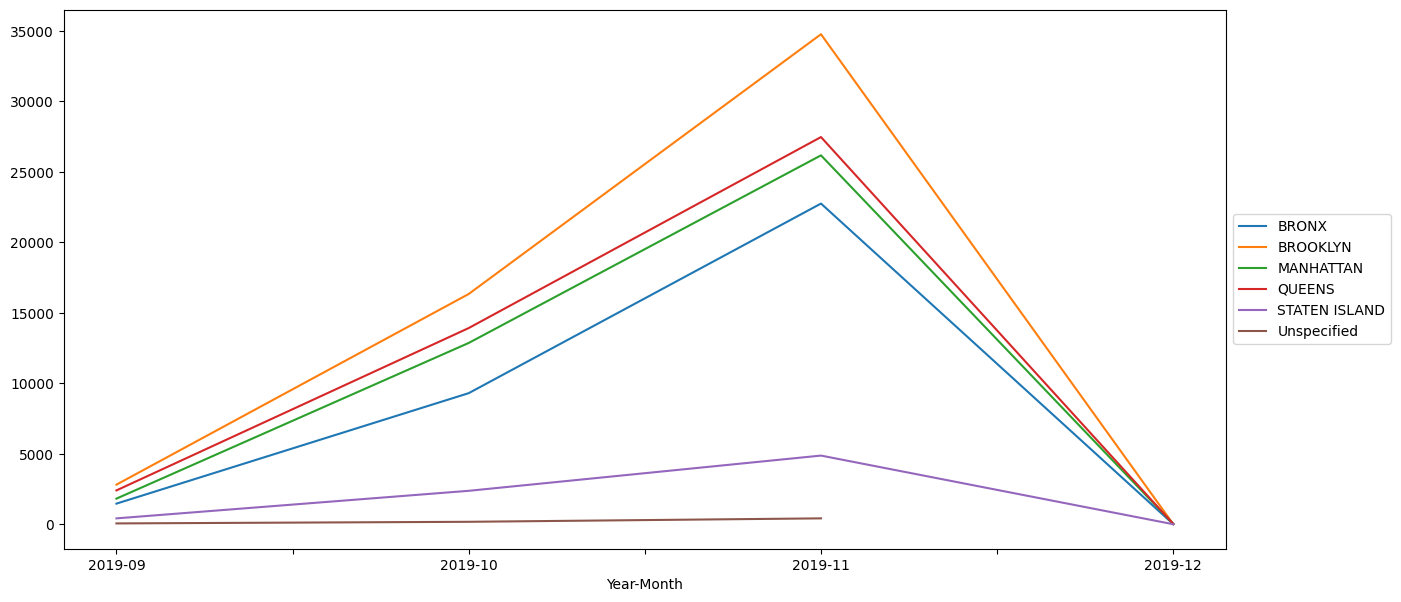

In [ ]:
# plotting Borough on the basis of Year-Month
df.groupby(['Year-Month','borough']).size().unstack().plot(figsize=(15,7))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

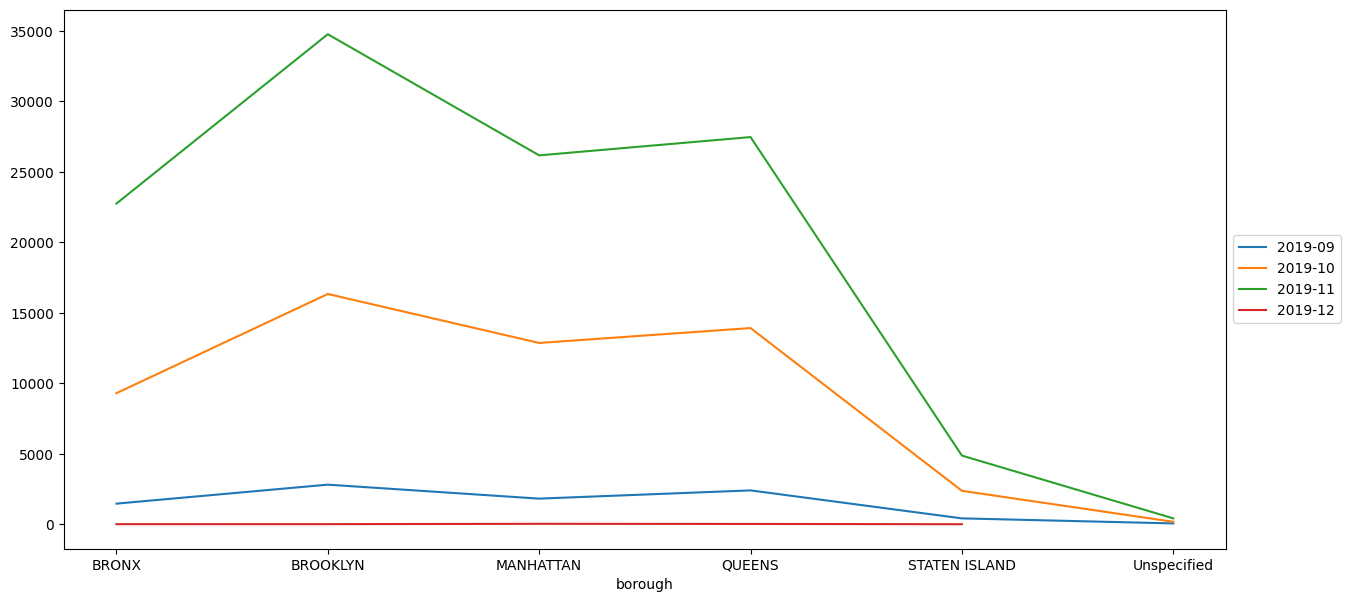

In [ ]:
# Plotting Year-Month on the basis of Borough
df.groupby(['borough', 'Year-Month']).size().unstack().plot(figsize=(15,7))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

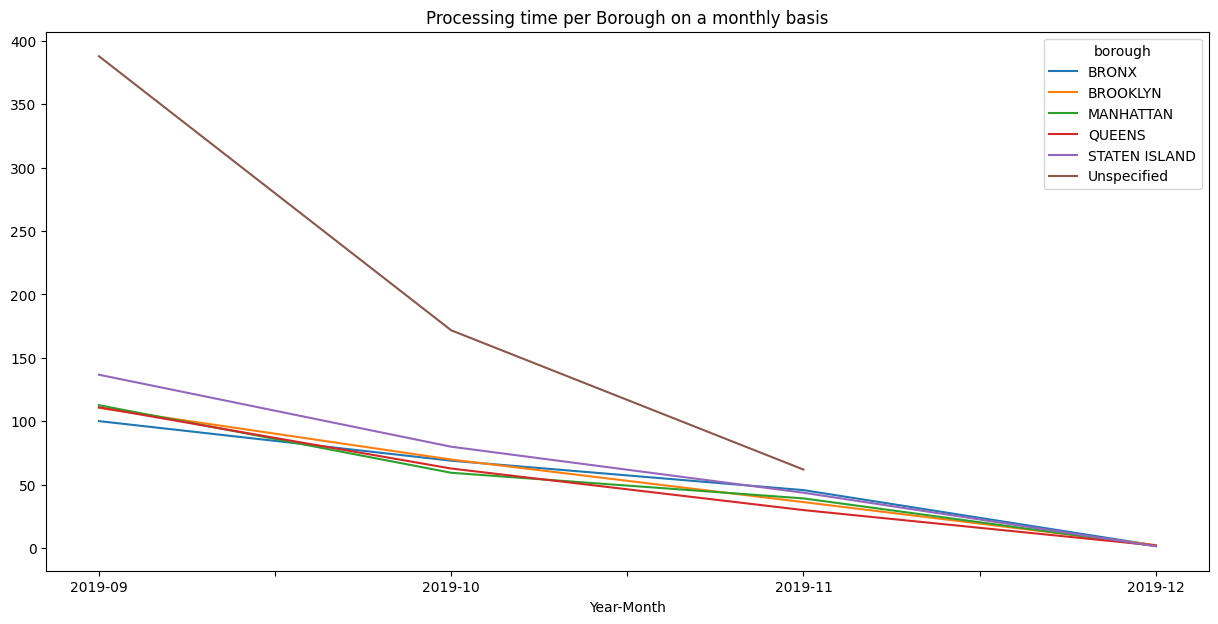

In [ ]:
# Processing time per Borough on a monthly basis
df.groupby(['Year-Month','borough'])['Request_Closing_Time_in_Hours'].mean().unstack().plot(figsize=(15,7),
                                                                        title='Processing time per Borough on a monthly basis');

## We will perform a statistical test for the following:

a. Whether the average response time across complaint types is similar or not

b. Are the type of complaint or service requested and location related?

In [ ]:
# lets see the average response time in seconds for different complaint types
avg_response_time = df.groupby(['complaint_type']).Request_Closing_Time_in_Seconds.mean().sort_values(ascending=True)
avg_response_time

,Request_Closing_Time_in_Seconds
complaint_type,
Street Light Condition,-1 days +09:36:42
Noise - Helicopter,0 days 00:00:02
Plant,0 days 01:43:00
Noise - House of Worship,0 days 02:33:14
Disorderly Youth,0 days 02:36:58
...,...
Drinking Water,30 days 06:58:12
Highway Sign - Dangling,37 days 00:16:49
New Tree Request,37 days 12:22:05


Null Hypothesis -->> Average response time across complaint types is similar.

Alternate Hypothesis -->> Average response time across complaint types is not similar.

We can say that for overall case our NULL HYPOTHESIS is rejected as the Average Response Time in Seconds for different complaint types is different

Testing for our Hypothesis
Below We conduct ANOVA test for top 5 type of complaints

For a 95% of confidence interval we choose our alpha as 0.05 for 5%

Alpha(0.05) is the critical p-value, if our calculated p-value is less than alpha, it will give us strong evidence to reject Null Hypothesis.

if p < alpha(0.05) : Reject Null Hypothesis, Average response time for all the complaints type is not same.

if p > alpha(0.05) : Fail to reject Null Hypothesis, Average response time for all the complaints type is same.

In [ ]:
# to calculate the p-value log of time taken to close the complaint per complaint is taken
data = {}
for complaint in df.complaint_type.unique():
    # Convert timedelta to total seconds before taking the logarithm
    # Filter out NaNs resulting from NaT conversion or other issues before dropping to avoid empty series
    log_times = np.log(df[df.complaint_type==complaint]['Request_Closing_Time_in_Seconds'].dt.total_seconds())
    data[complaint] = log_times.replace([-np.inf, np.inf], np.nan).dropna()

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
data.keys()

dict_keys(['Ferry Inquiry', 'Drinking', 'Rodent', 'Noise - Helicopter', 'Violation of Park Rules', 'Derelict Vehicles', 'Homeless Encampment', 'Illegal Parking', 'Noise', 'Lost Property', 'Maintenance or Facility', 'Noise - Commercial', 'Noise - Residential', 'Noise - Street/Sidewalk', 'Noise - Vehicle', 'Non-Emergency Police Matter', 'Sidewalk Condition', 'Street Condition', 'Street Sign - Damaged', 'Indoor Sewage', 'Public Payphone Complaint', 'Taxi Complaint', 'Abandoned Vehicle', 'Air Quality', 'Blocked Driveway', 'Broken Parking Meter', 'Homeless Person Assistance', 'Damaged Tree', 'New Tree Request', 'Vending', 'Traffic Signal Condition', 'Elevator', 'Special Projects Inspection Team (SPIT)', 'Consumer Complaint', 'Other Enforcement', 'Unsanitary Animal Pvt Property', 'General Construction/Plumbing', 'Street Light Condition', 'Lead', 'Noise - Park', 'APPLIANCE', 'ELEVATOR', 'Water System', 'DOOR/WINDOW', 'ELECTRIC', 'Emergency Response Team (ERT)', 'Building/Use', 'HEAT/HOT WATER

In [ ]:
for complaint in data.keys():
    print(data[complaint].std())

0.8722747710825993
1.4008101539074915
0.877760122181907
0.6130260286738666
2.229866544970542
1.6373326055628004
1.2772529247159425
1.254946251042947
1.5151293823696277
1.9507136676947632
1.7985767682893057
1.2802148030453673
1.3150448580373901
1.3152778284949107
1.4008862319044129
1.318720484452794
1.331570945609931
1.1558806352156978
1.5193584036168346
0.9106869720317193
0.5703718918772426
1.2367019454671138
1.5949785415672282
0.9809501348402941
1.2029984926701989
1.7669243901284415
2.1396841359842367
1.5819243071318865
0.4658688831626167
1.2292643596399475
1.64636328932299
1.4275437904650645
1.136841264386364
0.6475837983909207
0.915918816286413
0.8317376021871452
1.6428892858252795
1.4891478983275799
0.8061555725539752
1.3842346481377483
0.8907985850458321
0.8598915586058327
2.5957514572921503
0.8142041648020358
0.8625012083072389
1.5511947324416044
1.8563693161201988
0.8783466002941787
0.8260283593312072
0.9073598212122155
0.8336745882118265
1.219951070974678
1.2146974069074579
1.6

In [ ]:
# taking top 5 complaints
complaint_types_to_test = ['HEAT/HOT WATER', 'Illegal Parking', 'Noise - Street/Sidewalk', 'Noise - Residential', 'Blocked Driveway']

# Filter out empty data series before passing to f_oneway
valid_data_for_anova = []
for complaint in complaint_types_to_test:
    if complaint in data and not data[complaint].empty:
        valid_data_for_anova.append(data[complaint])
    else:
        print(f"Warning: Data for '{complaint}' is empty or not found after processing, skipping for ANOVA.")

# Perform ANOVA only if there are at least two non-empty groups
if len(valid_data_for_anova) >= 2:
    stat, p = f_oneway(*valid_data_for_anova)
    print('Statistics= %.3f, p = %.3f' % (stat, p))

    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('We have Different distributions (reject H0)')
else:
    print("Not enough valid data series (at least two) to perform ANOVA test for the selected complaint types.")

Statistics= 27504.079, p = 0.000
We have Different distributions (reject H0)


## We will conduct a Pearson Correlation Test on longitude and latitude



In [ ]:
# Drop rows with NaN values in 'latitude' or 'longitude' for correlation calculation
df_cleaned_for_corr = df.dropna(subset=['latitude', 'longitude']).copy()

# Calculate Pearson correlation coefficient and p-value cleaned dataset
correlation_coefficient, p_value = pearsonr(df_cleaned_for_corr.latitude, df_cleaned_for_corr.longitude)

print(f"Pearson correlation coefficient (r): {correlation_coefficient}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("The correlation is statistically significant (reject the null hypothesis of no correlation).")
else:
    print("The correlation is not statistically significant (fail to reject the null hypothesis of no correlation).")

Pearson correlation coefficient (r): 0.35077810287475586
P-value: 0.0
The correlation is statistically significant (reject the null hypothesis of no correlation).


Magnitude:
  0.2 to 0.4: Weak, low linear correlation.
  
Direction (Type of the Relationship):

  Positive (r > 0): This means that as latitude increases, longitude also tends to increase.


## Building a Regression Model to Predict Response Time with complaint_type, borough and time features

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180463 entries, 4 to 209994
Data columns (total 26 columns):
 #   Column                           Non-Null Count   Dtype          
---  ------                           --------------   -----          
 0   unique_key                       180463 non-null  float64        
 1   created_at                       180463 non-null  datetime64[ns] 
 2   closed_at                        180463 non-null  datetime64[ns] 
 3   resolution_date_update           178555 non-null  datetime64[ns] 
 4   resolution_description           175157 non-null  object         
 5   days_to_close                    179301 non-null  float64        
 6   agency                           180463 non-null  object         
 7   agency_name                      180463 non-null  object         
 8   complaint_type                   180463 non-null  object         
 9   descriptor                       175829 non-null  object         
 10  location_type                    1289

In [ ]:
training_data_cols = [df.complaint_type, df.borough, df['Year-Month']]

x = []
vectorizers = []

# Convert text variables to a sparse matrix with vectorizer
for item in training_data_cols:
  vectorizer = CountVectorizer()
  x.append(vectorizer.fit_transform(item))
  vectorizers.append(vectorizer)

In [ ]:
print(len(x))

3


In [ ]:
# Combine x array into a single 1D array with hstack
x_combined = hstack(x)

# Store feature variables for only values
y = df.days_to_close.values

# Create a boolean mask to identify non-NaN values in the target
non_nan_mask = ~np.isnan(y)

# Apply the mask to both X_combined and y to remove rows with NaN in the target
X_filtered = x_combined[non_nan_mask]
y_filtered = y[non_nan_mask]

# Now, split the filtered data
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=0)

In [ ]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Make predictions on the test set
predictions = model.predict(X_test)
print(predictions)

[ 2.45783976  3.06548072 -0.14807396 ...  0.13464997  0.8137967
  0.00667156]


In [ ]:
# calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 15.021757564051759
Root Mean Squared Error: 3.875791217809824
R-squared: 0.39839398991078645


In [ ]:
df.city.value_counts()

,count
city,
BROOKLYN,50866
NEW YORK,36334
BRONX,31511
STATEN ISLAND,7270
JAMAICA,4374
ASTORIA,3126
FLUSHING,2886
RIDGEWOOD,2731
FRESH MEADOWS,1762


In [ ]:
test = ['HEAT/HOT WATER', 'QUEENS', '2010-01']

# Transform each element of the test_input using its corresponding fitted vectorizer
def input_transfrom(test_input):
  transformed_test_features = []
  for i, feature_value in enumerate(test_input):
    transformed_test_features.append(vectorizers[i].transform([feature_value]))

  # Horizontally stack the transformed features and return the transformed input
  return hstack(transformed_test_features)


# Make prediction
predicted_days = model.predict( input_transfrom(test) )
print(f"Predicted days to close for the test input: {predicted_days[0]:.2f} days")

Predicted days to close for the test input: 3.05 days
